# Setup

## Librerías, modulos y configuración de la notebook 

In [2]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [3]:
#### Configuraciones de la notebook ####
#pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [4]:
#### Parametros de la notebook ####
path_save = '../datos/'
# actualizado al 1/03 
dolar_blue = 206 # 196
dolar_oficial = 114.18

## Load data

In [4]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-03-02.pkl'.format(path_save))

In [5]:
df.shape

(2592757, 42)

# Data Cleaning/Preprocessing 

### *Eliminar duplicados*

In [6]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [7]:
df.shape

(141300, 42)

### *Eliminar 11111 & 999999*

**Dropeamos valores como 111111 o 999999 (ya sean outliers o no)** --> ESTO HAY QUE SUMARLO AL PROCESAMIENTO DE LAS SIMULACIONES !!! <br> 
* Pueden existir casos donde estos valores extraños no sean outliers, por lo tanto no los vamos a conseguir limpiar cuando dropiemos outliers. Es por eso que desarrollamos el siguiente metodo
* Es clave hacerlo en este momento sobre "price_amount" y no luego sobre "price_meli_ok" ya que hay casos en los que el price simbol es USD y luego cuando lo multiplicamos por el TC para pasar a "price_meli_ok" dejan de cumplir estas condiciones de ser 111111 o 999999 y les perdemos el rastro

In [8]:
df['price_amount'] = df.price_amount.astype('int')

In [9]:
m1 = df.price_amount == 1111
m2 = df.price_amount == 11111
m3 = df.price_amount == 111111
m4 = df.price_amount == 1111111
m5 = df.price_amount == 11111111
m6 = df.price_amount == 111111111

len(df[m1 | m2 | m3 | m4 | m5 | m6])

56

In [10]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
524523,1111111
1458955,1111111
790992,111111
16400,1111111
2039819,111111


In [11]:
df.shape

(141300, 42)

In [12]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6)]

In [13]:
df.shape

(141244, 42)

*Ahora lo mismo pero para los casos 999999*

In [14]:
m1 = df.price_amount == 9999
m2 = df.price_amount == 99999
m3 = df.price_amount == 999999
m4 = df.price_amount == 9999999
m5 = df.price_amount == 99999999

len(df[m1 | m2 | m3 | m4 | m5])

91

In [15]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
1719537,9999999
2280515,999999
879539,999999
1191754,9999999
2227256,999999


In [16]:
df.shape

(141244, 42)

In [17]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [18]:
df.shape

(141153, 42)

*Ahora lo mismo para kms*

In [19]:
df['car_kms'] = df.car_kms.astype('int')

In [20]:
df[df.car_kms > 0]['car_kms'].min()

1

In [21]:
m1 = df.car_kms == 1
m2 = df.car_kms == 11
m3 = df.car_kms == 111
m4 = df.car_kms == 1111
m5 = df.car_kms == 11111
m6 = df.car_kms == 111111
m7 = df.car_kms == 1111111
m8 = df.car_kms == 11111111

len(df[ m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8])

924

In [22]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8][['car_kms']].head()

,car_kms
1719111,1111
680944,11111
422194,111111
781622,111111
1014717,111111


In [23]:
df.shape

(141153, 42)

In [24]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8)]

In [25]:
df.shape

(140229, 42)

*Lo mismo pero para los valores 99999*

In [26]:
m1 = df.car_kms == 999
m2 = df.car_kms == 9999
m3 = df.car_kms == 99999
m4 = df.car_kms == 999999
m5 = df.car_kms == 9999999

len(df[m1 | m2 | m3 | m4 | m5])

74

In [27]:
# observamos
df[m1 | m2 | m3 | m4 | m5][['car_kms']].head()

,car_kms
1919141,999999
1215096,99999
366450,99999
1406759,9999
1665038,999999


In [28]:
df.shape

(140229, 42)

In [29]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [30]:
df.shape

(140155, 42)

In [31]:
# checkpoint
df.to_csv('{}df_checkpoint_1.pkl'.format(path_save))

In [32]:
df = pd.read_csv('{}df_checkpoint_1.pkl'.format(path_save))
df.shape

(140155, 43)

### *Precio final*

In [33]:
#Dropeamos los precios en dolares** --> Al final no lo hicimos
#Representan un 14% de la base !!! Caía mucho el test sin estos casos
# # observamos su volumen
# mask = df.price_symbol == 'U$S'
# display(df[mask].shape)
# display(round(df[mask].shape[0]/len(df),2))
# # dropeamos
# df.drop(list(df[mask].index),axis=0,inplace=True)
# display(df.shape)

In [34]:
# Construcción del precio final
blue= dolar_blue
oficial= dolar_oficial
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

### *Dropeamos 0kms y concesionaria*

In [35]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [36]:
df.shape

(58747, 44)

### *Dropeamos match_score por debajo de 50%*

In [37]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=80]
    
# chequeo
df[lst].min()

score_marca_a    92.00
score_modelo_a   86.00
score_v1_c       80.00
dtype: float64

In [38]:
df.shape

(46181, 44)

### *Dropeamos registros que no sean de los ultimos 15 días*

In [39]:
df.runtime.max()

'2022-03-01 23:01:47'

In [40]:
from datetime import date, datetime, timedelta

In [41]:
df['runtime'] = df['runtime'].apply(pd.to_datetime)

In [42]:
df[['runtime','price_meli_ok']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46181 entries, 0 to 140151
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   runtime        46181 non-null  datetime64[ns]
 1   price_meli_ok  46181 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 MB


In [43]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [44]:
df.runtime.max()

Timestamp('2022-03-01 23:01:47')

In [45]:
print(df.runtime.min())
print(df.runtime.max())

2022-02-15 00:00:23
2022-03-01 23:01:47


In [46]:
df.shape

(37439, 44)

### *Tratamiento de outliers nº1*

*Vamos a eliminar solamente los outliers más absurdos antes de hacer el split*

In [47]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [48]:
df.price_meli_ok.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count       37439.00
mean      2620430.71
std       2839481.39
min        200000.00
0.5%       550000.00
1%         620000.00
25%       1320000.00
50%       1970000.00
75%       3150000.00
99%      10097720.00
99.5%    13183960.86
99.8%    17510000.00
99.9%    24062860.00
max     195700000.00
Name: price_meli_ok, dtype: float64

In [49]:
# Asi como aca aparece esta Hilux, este tipo de casos los tratamos en el tratamiento de outliers nº2
df[df.price_meli_ok <= 250000][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
81642,2021,960000,FIAT,Cronos,1.3 GSE MT Drive Pack Conectividad (99cv),DRIVE 1.3 MT,Gama Pequenos Sedan,Gama Pequenos
93535,2016,2000,TOYOTA,Hilux,2.5 TDI C/D 4x4 DX Pack 2ABG ABS (120cv),4X4,Pickups Medianas-Grandes,Livianos


In [50]:
df.shape

(37439, 44)

<AxesSubplot:xlabel='price_meli_ok'>

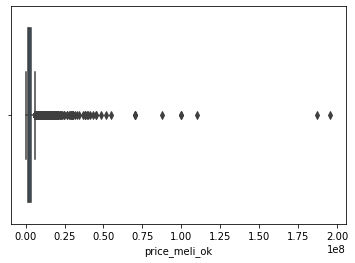

In [51]:
sns.boxplot(df.price_meli_ok)

In [52]:
# creamos diccionarios para guardar la info de capeo de outliers
thresh_outliers_1 = {}

In [53]:
# dropmeamos outliers globales de price
p_995 = df.price_meli_ok.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['price_p995'] = p_995
mask = df.price_meli_ok <= p_995
df = df[mask]

<AxesSubplot:xlabel='price_meli_ok'>

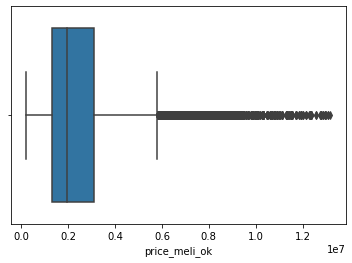

In [54]:
sns.boxplot(df.price_meli_ok)

In [55]:
df.price_meli_ok.describe(percentiles=[0.001,0.01,0.05,0.1,0.25,0.75,0.99])

count      37251.00
mean     2514720.29
std      1777326.69
min       200000.00
0.1%      450000.00
1%        620000.00
5%        800000.00
10%       905000.00
25%      1300000.00
50%      1950000.00
75%      3100000.00
99%      9102600.00
max     13183794.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

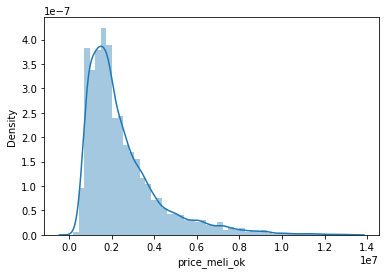

In [56]:
sns.distplot(df.price_meli_ok)

In [57]:
# Observamos los casos --> Podemos ver que hay casos como una Kangoo, KA, etc con precios absurdamente altos.
## Casos de este tipo trataremos en el tratamiento de outliers nº2
p_99 = df.price_meli_ok.quantile(0.99)
mask = df.price_meli_ok >= p_99
df[mask][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
24119,2014,30000,CHEVROLET,Camaro,SS V8 6.2 8AT (461cv) (L17),SS,Premium,Premium
24148,2018,17500,BMW,Serie 2,M240i Cabrio Package M (340cv),3,SUV Premium,SUV
26244,2018,27000,BMW,Serie 4,430i Gran Coupé Sport (252cv),2.2,SUV Premium,SUV
26358,2020,12500,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
26465,2019,35000,BMW,X1,20i sDrive SportLine (192cv),20I,SUV Premium,SUV
27492,2018,11000,MERCEDES BENZ,Clase C,250 AT AMG-Line (211cv) (W205) Sedán,250,Premium,Premium
28121,2019,25000,CITROEN,C4 Cactus,1.2 Puretech S&S AT6 Rip Curl (110cv),CACTUS PURETECH 110 S&S AT6 RIP CURL,SUV 4X2,SUV
28196,2021,3600,MINI,Cooper,Countryman SD 2.0 Pepper 6MT (143cv),S,Gama Pequenos Premium,Gama Pequenos
28470,2018,2500,FORD,Mustang,GT 5.0L 6MT (421cv),GT,Premium,Premium
28816,2020,22000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos


In [58]:
df.shape

(37251, 44)

*Ahora lo mismo pero para kms**

In [59]:
df.car_kms.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count     37251.00
mean     107745.06
std       79082.21
min          99.00
0.5%       1000.00
1%         2700.00
25%       60000.00
50%       99000.00
75%      145000.00
99%      300000.00
99.5%    350000.00
99.8%    420000.00
99.9%    590500.00
max     3112500.00
Name: car_kms, dtype: float64

<AxesSubplot:xlabel='car_kms'>

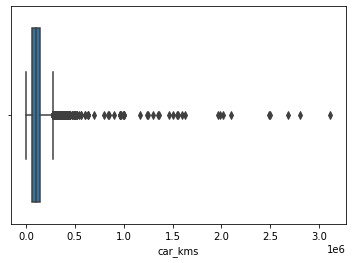

In [60]:
sns.boxplot(df.car_kms)

In [61]:
p_995 = df.car_kms.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['kms_p995'] = p_995
mask = df.car_kms > p_995
len(df[mask])

174

In [62]:
# dropeamos outliers globales de car_kms
df = df[~mask]

In [63]:
# We are now able to save the dict with the information learned in the train set regarding the thresholds to cap outliers
import json
with open(f'{path_save}thresh_outliers_1.json', 'w') as fp:
    json.dump(thresh_outliers_1, fp)

<AxesSubplot:xlabel='car_kms'>

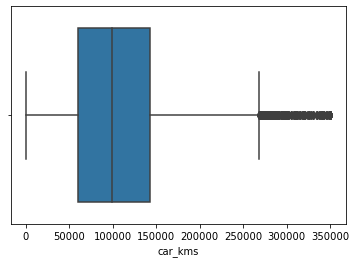

In [64]:
sns.boxplot(df.car_kms)

*Revision valores extremos o raros en car_year*

In [65]:
df.car_year.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.998,0.999])

count   37077.00
mean     2013.74
std         3.70
min      2006.00
0.5%     2006.00
1%       2006.00
25%      2011.00
50%      2014.00
75%      2017.00
99%      2021.00
99.8%    2021.00
99.9%    2021.00
max      2021.00
Name: car_year, dtype: float64

Vemos que no hay outliers ni casos raros en la variable de año

In [66]:
sorted(df.car_year.unique().tolist())

[2006,
 2007,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

ATENCIÓN: No tenemos datos para 2008.

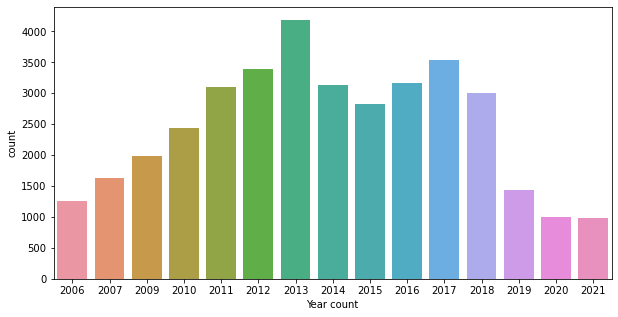

In [67]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
sns.countplot(df.car_year)
plt.xlabel("Year count")
plt.show()

*Data inconsistencies:*
* No tenemos datos de 2008
* La distribución es bastante simetrica y normal
* Tenemos un spike para los autos del 2013

***Fin del tratamiento de outliers nº1***

### *Dropeamos categorías que no nos sirven*

*Las categorías que dejamos afuera, son las que no nos interesa cotizar porque irán a reglas o al equipo de pricing*

Los grupos de los escenarios los vamos a re-definir aca. Debido a que cuando lo hicimos en la nb "Tres escenarios" como un primer apporach estaba bien y aparte el objetivo era validar la hipotesis de outliers vs presencia. Pero ocurre que aca el procesamiento es más profundo, y por lo tanto un auto que capas estaba en el grupo 4 en la nb "Tres Escenarios" aca debido a las limpiezas extra respesto a esa nb, pierden muchisimo volumen y quedaría en grupos muchísimos más bajos que no entrarían para el algoritmo. El caso perfecto es la F-150 de FORD: en ese caso en la nb "Tres Esce" quedaba en el grupo 4, y aca desp de todo el procesamiento nos queda 1 solo caso el cual se nos fue a test despues de split y en train no estaba, por lo tanto tira error la funcion de data_processing_1().

In [68]:
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

In [69]:
df_grouped.head(10)

,marca,modelo,version,cant
1960,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),359
1346,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),276
1919,VOLKSWAGEN,Gol,1.6 3Ptas. Power,276
1948,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),252
1550,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,250
1296,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),231
1759,TOYOTA,Corolla,XEI 1.8 CVT (140cv) (L18),228
1818,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),224
794,FORD,Fiesta,1.6 Titanium Powershift (120cv) 5Ptas.,220
1878,VOLKSWAGEN,Bora,2.0 Trendline MT,215


In [70]:
df_grouped.tail(10)

,marca,modelo,version,cant
1103,LAND ROVER,Freelander,HSE 2.0 TD4 AT 5Ptas.,1
1102,LAND ROVER,Discovery,Sport SE,1
645,FIAT,Linea,1.9 N 16v Dualogic Essence (132cv),1
1101,LAND ROVER,Discovery,Sport HSE,1
647,FIAT,Linea,1.9 N 16v MT Essence (132cv),1
1100,LAND ROVER,Discovery,4 3.0 SDV6 HSE Black Edition,1
1811,TOYOTA,Hilux,4x2 CD STD 2.4 TDI 6MT (150cv) (L16),1
1099,LAND ROVER,Discovery,4 2.7 TDV6 HSE (190cv),1
1097,LAND ROVER,Defender,110 SW 2.4 Alloy,1
1345,PEUGEOT,308,Allure 1.6 HDI (115cv) 5ptas.,1


In [112]:
mask = df_grouped['marca'] == 'VOLKSWAGEN'
df_grouped[mask].sort_values(by='modelo')

,marca,modelo,version,cant
1842,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Doble Trendline (L17),1
1874,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Comfortline AT ...,22
1848,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x2 C/Doble Startline 2ABG,4
1846,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x4 C/Simple Startline,23
1860,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Startline,24
1853,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Trendline,24
1850,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Highline Black,4
1858,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Highline (L17) DIS...,4
1854,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Comfortline (L17),46
1870,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Startline,3


In [71]:
# agrupacion
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()

data = df_grouped.copy()
data.sort_values(by='cant',ascending=False,inplace=True)

data['cuantiles' + str('_'+'cant')] =pd.qcut(data['cant'], 10, duplicates='drop')

placeholder= 'marca'
tmp = data.groupby('cuantiles' + str('_'+'cant')).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
leni = len(tmp)
tmp['cuantil' + str('_'+'cant')] = list(reversed(list(np.arange(1,leni+1,1))))
tmp['bin' + str('_'+'cant')] = tmp.index
tmp.reset_index(drop=True,inplace=True)
tmp.drop('placeholder',1,inplace=True)

data = data.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+'cant')], right_on='bin' + str('_'+'cant'))

#data.drop(cols_to_drop,1,inplace=True)

#df_output = df_output.merge(data, on=['marca','modelo','version'])

# seleccion y orden final de las columnas del output
#df_output_ok = df_output[['marca','modelo','version','cant','cuantil_cant','bin_cant']]
#df_output_ok.sort_values(by='cant',ascending=False,inplace=True)
#df_output_ok.head()

In [72]:
data.drop('cuantiles_cant',1,inplace=True)

In [73]:
asd = (data.groupby('cuantil_cant')['cant'].sum()/sum(data.cant))*100
asd

cuantil_cant
1   54.63
2   18.71
3    9.87
4    6.14
5    3.75
6    2.96
7    1.27
8    2.66
Name: cant, dtype: float64

In [74]:
tmp

,cuantil_cant,bin_cant
0,8,"(0.999, 2.0]"
1,7,"(2.0, 3.0]"
2,6,"(3.0, 5.0]"
3,5,"(5.0, 8.0]"
4,4,"(8.0, 13.0]"
5,3,"(13.0, 23.0]"
6,2,"(23.0, 47.3]"
7,1,"(47.3, 359.0]"


In [75]:
# Escenario de cotizacion: Algoritmo
print(f'Algoritmo: {asd.iloc[0:4].sum()}')
print(f'Reglas: {asd.iloc[4:7].sum()}')
print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

Algoritmo: 89.3572834911131
Reglas: 7.980688836745152
Equipo Pricing: 2.6620276721417593


In [76]:
# Marcas-modelos en cada grupo
data['marca_modelo'] = data['marca'] + str(' - ') +data['modelo']
data.head()

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),359,1,"(47.3, 359.0]",VOLKSWAGEN - Gol Trend
1,VOLKSWAGEN,Gol,1.6 3Ptas. Power,276,1,"(47.3, 359.0]",VOLKSWAGEN - Gol
2,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),276,1,"(47.3, 359.0]",PEUGEOT - 308
3,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),252,1,"(47.3, 359.0]",VOLKSWAGEN - Gol Trend
4,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,250,1,"(47.3, 359.0]",RENAULT - Kangoo


In [77]:
data[data.modelo == 'Tiggo']

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo
107,CHERY,Tiggo,2.0 16v 4x2 Confort (138cv),76,1,"(47.3, 359.0]",CHERY - Tiggo
586,CHERY,Tiggo,2.0 16v 4x4 Luxury (138cv),15,3,"(13.0, 23.0]",CHERY - Tiggo
1199,CHERY,Tiggo,2.0 16v 4x2 Luxury AT (138cv),4,6,"(3.0, 5.0]",CHERY - Tiggo


In [78]:
# Marcas-modelos en cada grupo
sorted(list(data[data['cuantil_cant']==1]['marca_modelo'].unique()))

['AUDI - A1',
 'AUDI - A3',
 'AUDI - Q5',
 'CHERY - Tiggo',
 'CHEVROLET - Agile',
 'CHEVROLET - Astra II',
 'CHEVROLET - Aveo',
 'CHEVROLET - Celta',
 'CHEVROLET - Classic',
 'CHEVROLET - Cruze',
 'CHEVROLET - Meriva',
 'CHEVROLET - Onix',
 'CHEVROLET - Prisma',
 'CHEVROLET - S-10',
 'CHEVROLET - Tracker',
 'CITROEN - Berlingo',
 'CITROEN - C3',
 'CITROEN - C4',
 'CITROEN - C4 Lounge',
 'DODGE - Journey',
 'FIAT - 500',
 'FIAT - Cronos',
 'FIAT - Fiorino',
 'FIAT - Mobi',
 'FIAT - Palio',
 'FIAT - Punto',
 'FIAT - Qubo',
 'FIAT - Siena',
 'FIAT - Strada',
 'FIAT - Toro',
 'FIAT - Uno',
 'FORD - EcoSport',
 'FORD - Fiesta',
 'FORD - Focus',
 'FORD - Focus III',
 'FORD - KA',
 'FORD - Ranger',
 'HONDA - CRV',
 'HONDA - Civic',
 'HONDA - Fit',
 'HONDA - HR-V',
 'JEEP - Compass',
 'JEEP - Renegade',
 'NISSAN - Tiida',
 'PEUGEOT - 2008',
 'PEUGEOT - 206',
 'PEUGEOT - 207',
 'PEUGEOT - 208',
 'PEUGEOT - 307',
 'PEUGEOT - 308',
 'PEUGEOT - 408',
 'PEUGEOT - Partner',
 'RENAULT - Captur',
 'RE

In [79]:
grupos_df = data.copy()
# nos quedamos únicamente con los grupos que entran al modelo
grupos_df_algor = grupos_df[grupos_df['cuantil_cant'].apply(lambda x: x in [1,2,3])]
# check
grupos_df_algor.cuantil_cant.unique()

array([1, 2, 3])

In [80]:
# Nos quedamos unicamente con los marca-modelo-version dentro de los grupos 1, 2, 3 y 4
marcas_ok = list(grupos_df_algor.marca.unique())
modelos_ok = list(grupos_df_algor.modelo.unique())
versiones_ok = list(grupos_df_algor.version.unique())
# guardamos las marcas_ok y los modelos_ok ya que son los únicos que nos van a interesar scorear
pd.Series(marcas_ok).to_csv('{}marcas_ok.csv'.format(path_save))
pd.Series(modelos_ok).to_csv('{}modelos_ok.csv'.format(path_save))
pd.Series(versiones_ok).to_csv('{}versiones_ok.csv'.format(path_save))

mask1 = df.match_marca_a.apply(lambda x: x in marcas_ok)
mask2 = df.match_modelo_a.apply(lambda x: x in modelos_ok)
mask3 = df.match_v1_a.apply(lambda x: x in versiones_ok)

df = df[mask1 & mask2 & mask3]

In [81]:
sorted(list(df.match_marca_a.unique()))

['ALFA ROMEO',
 'AUDI',
 'BMW',
 'CHERY',
 'CHEVROLET',
 'CHRYSLER',
 'CITROEN',
 'DODGE',
 'DS',
 'FIAT',
 'FORD',
 'HONDA',
 'HYUNDAI',
 'JEEP',
 'KIA',
 'MERCEDES BENZ',
 'MINI',
 'MITSUBISHI',
 'NISSAN',
 'PEUGEOT',
 'RENAULT',
 'SUZUKI',
 'TOYOTA',
 'VOLKSWAGEN']

In [82]:
# cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
#            ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
# mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
# cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
#  'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
#  'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
# mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
# sub_mask = df.brand == 'Jeep'
# lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
# mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
# df = df[(mask1 & mask2 & mask3)]

In [83]:
df.shape

(31094, 44)

### Salvamos el dataset listo para el split

In [84]:
df.to_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [85]:
df = pd.read_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [86]:
df.shape

(31094, 45)

# Split

In [87]:
###### Split #######

X = df[model_features]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(24875, 8) (6219, 8)


In [88]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,24875.00,6219.00
mean,2437917.14,2435260.67
std,1657370.27,1653611.01
min,300000.00,200000.00
0.1%,479496.00,466540.00
1%,650000.00,650000.00
10%,950000.00,920000.00
25%,1320000.00,1300000.00
50%,1920000.00,1940000.00
75%,3000000.00,3000000.00


<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

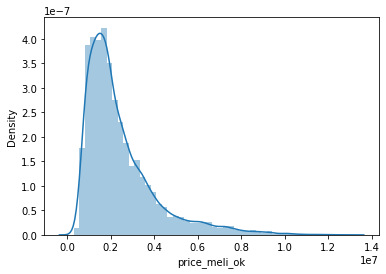

In [89]:
sns.distplot(y_train)

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

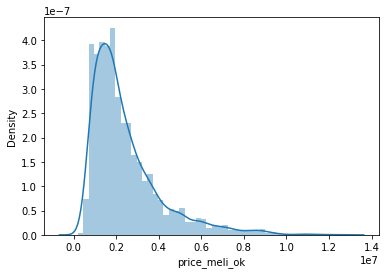

In [90]:
sns.distplot(y_test)

In [91]:
# chequeamos distribuciones de kms en ambos dfs
a = pd.concat([X_train.car_kms.describe(percentiles=[0.005,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,X_test.car_kms.describe(percentiles=[0.005, 0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['kms_train','kms_test']
a

,kms_train,kms_test
count,24875.00,6219.00
mean,103565.34,103409.03
std,59601.12,60100.68
min,99.00,122.00
0.5%,1037.40,1000.00
1%,3338.18,3018.00
10%,30000.00,30000.00
25%,60000.00,58000.00
50%,97500.00,98000.00
75%,140000.00,140000.00


In [92]:
df_train = pd.concat([X_train,y_train],1)
df_test = pd.concat([X_test,y_test],1)

De ahora en más trabajamos solo sobre df_train para evitar data leakage.

In [93]:
del df

### Salvamos los df de train y test

In [94]:
df_train.to_csv('{}df_train_checkpoint_3.pkl'.format(path_save))
df_test.to_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

# Univariado + Bivariado + Cleaning

* Luego volver a correr este bivariado pero sumandole el nivel año a la agregación, luego y hacer una funcion que capee los valores que traspasen los whiskers en cada agrupacion (ej: toyota - hilux - 2020) tanto para km como para precios.
* Usar la version acara en lugarde la de camval
* Mirar los errores en la perfo del modelo, no solo el R2 (la func evaluate que use para airtm)

In [95]:
df_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'match_v1_c', 'Subseg_a', 'Seg_a', 'price_meli_ok'],
      dtype='object')

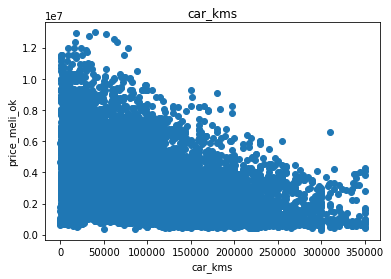

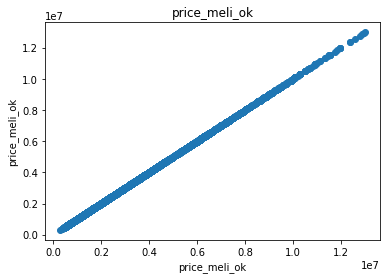

In [96]:
for feature in ['car_kms','price_meli_ok']:
    plt.scatter(df_train[feature],df_train['price_meli_ok'])
    plt.xlabel(feature)
    plt.ylabel('price_meli_ok')
    plt.title(feature)
    plt.show()

In [97]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Hilux', 'Yaris', 'Corolla', 'Etios'], dtype=object)

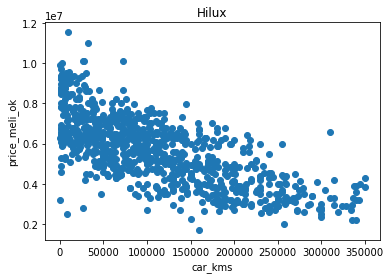

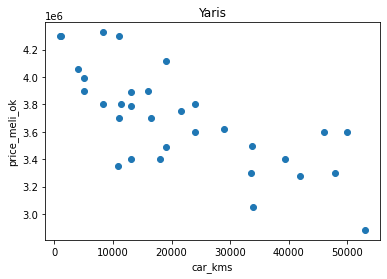

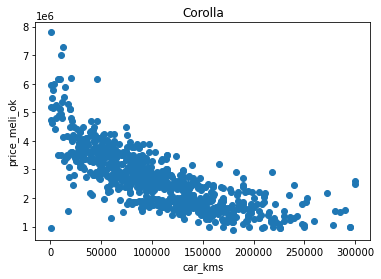

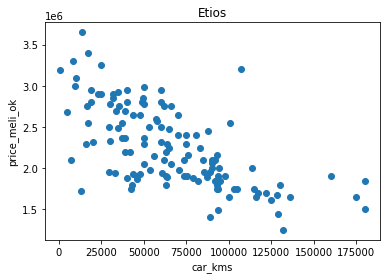

In [98]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.scatter(data[sub_mask]['car_kms'],data[sub_mask]['price_meli_ok'])
    plt.xlabel('car_kms')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

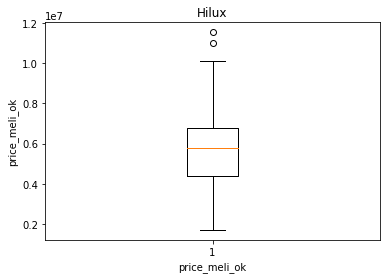

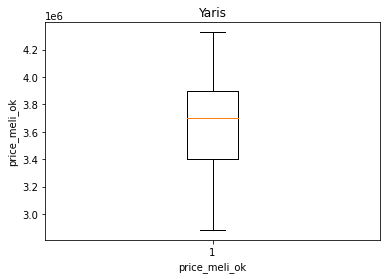

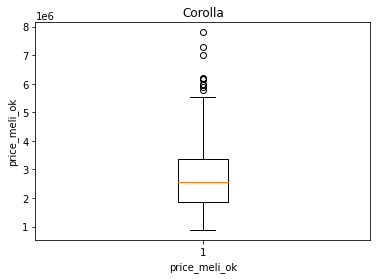

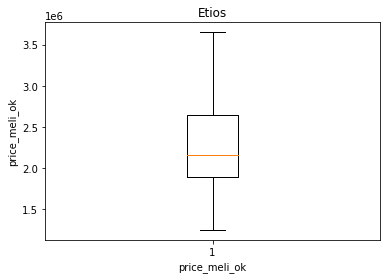

In [99]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['price_meli_ok'])
    plt.xlabel('price_meli_ok')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

Vamos a chequear si los detectamos con la formula q3+1.5*IQR

In [100]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

3783250.0
0


In [101]:
mask = df_train.match_modelo_a == 'Hilux'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

10400000.0
2


Perfect

*Lo mismo para kms*

In [102]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Hilux', 'Yaris', 'Corolla', 'Etios'], dtype=object)

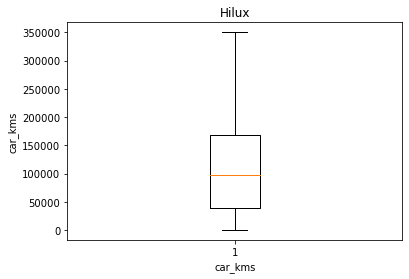

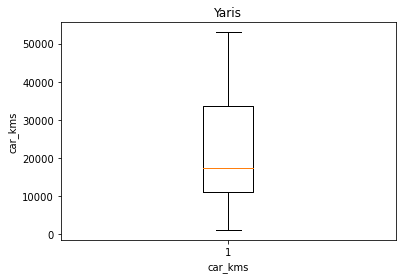

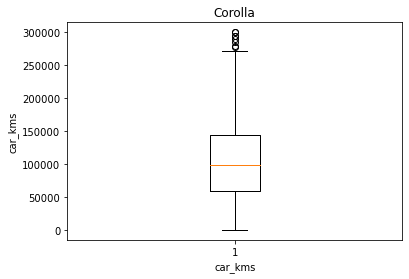

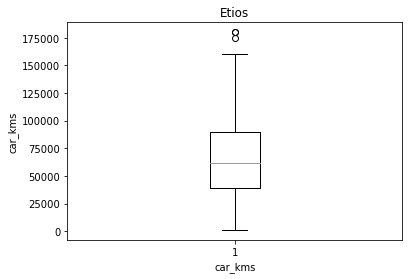

In [103]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['car_kms'])
    plt.xlabel('car_kms')
    plt.ylabel('car_kms')
    plt.title(i)
    plt.show()

In [104]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

166500.0
3


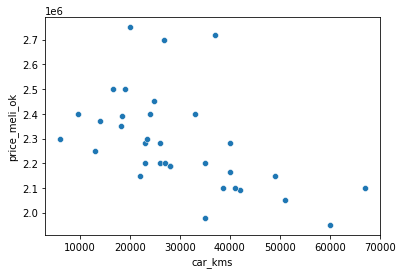

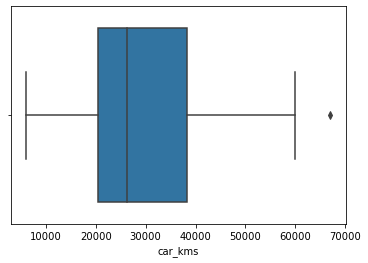

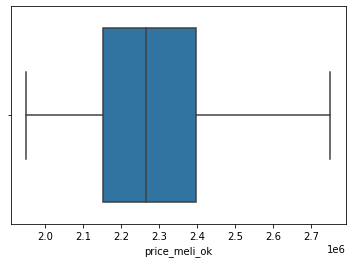

In [105]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

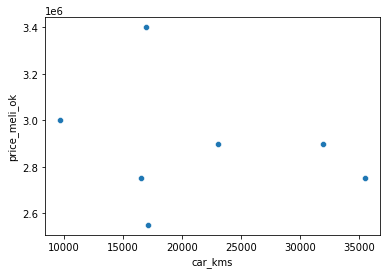

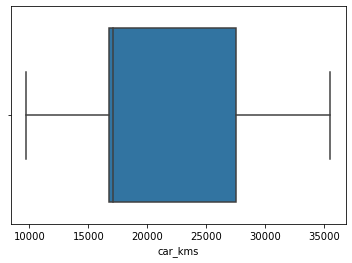

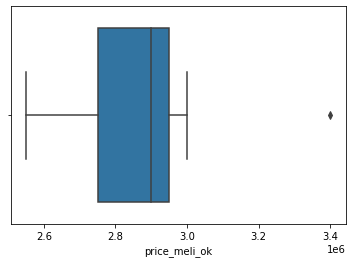

In [106]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

In [107]:
mask1 = df_train.match_modelo_a == 'Etios'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

43750.0
0


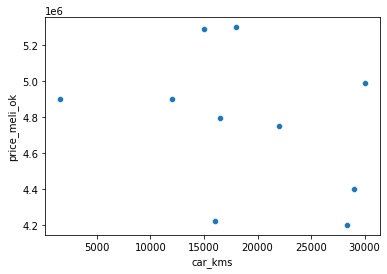

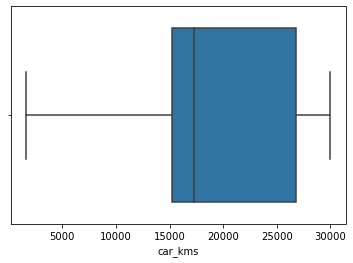

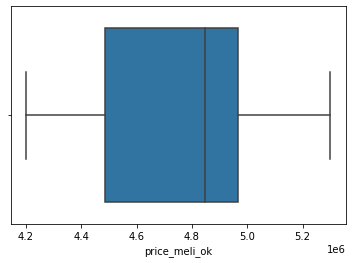

In [117]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'T-Cross'
#mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2]['car_kms'],df_train[mask1 & mask2]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2]['price_meli_ok'],)
plt.show()

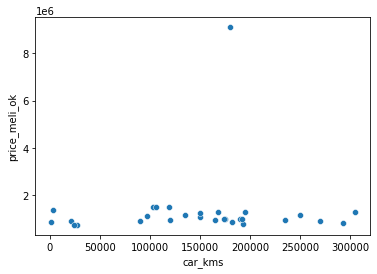

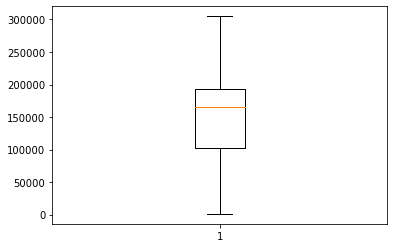

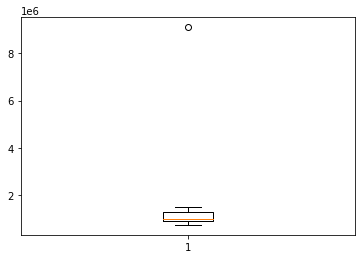

In [118]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

Aca podemos chequear el valor extremo de la Kangoo que hace que haya aparecido cuando nos fijamos los registros que quedaban por encima del p99 luego de haber hecho el tratamiento de outliers nº1.

También es interesante observar en el boxplot de kms como sale un outlier inferior: es imposible (o demasiado raro) que una kangoo del 2009 tenga menos de 10.000 kms. Todos estos casos ilogicos los vamos a estar eliminando en esta seccion "Tratamiento de outliers nº2"

In [121]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

1875000.0
1


In [122]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_inferior = q1-1.5*IQR
print(outl_thresh_inferior)
print(len(data[data.price_meli_ok<outl_thresh_inferior]))

315000.0
0


---

### *Tratamiento de outliers nº2*
* Es un tratamiento profundo donde buscamos **outliers por contexto** (outliers a nivel de agg marca-modelo-año)
* Notar que se hace despues del Split sobre el train, para evitar data leakage! Es decir: fit_transform sobre train y transform sobre test
* Luego lo aplicaremos sobre test pero con los thresholds de outliers aprendidos en train.

In [123]:
# Dropeamos todos los outliers por contexo: "Tratamiento de outliers nº2"

modelos = sorted(list(df_train.match_modelo_a.unique()))
años = sorted(list(df_train.car_year.unique()))
kms_thresh_outliers = {}
price_thresh_outliers = {}
old_shape = df_train.shape[0]
for m in modelos:
    for a in años:
        # print(f'{m} of {a}') --> solo para chequear que el loop este iterando correctamente (esta OK :)
        
        modelo_año = m + '_' + str(a)
        
        
        # kms
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.car_kms.quantile(0.25)
        q3 = data.car_kms.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        kms_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.car_kms>kms_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.car_kms<kms_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)
        
        # price
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.price_meli_ok.quantile(0.25)
        q3 = data.price_meli_ok.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        price_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.price_meli_ok>price_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.price_meli_ok<price_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)

print(f'Hey! {old_shape - df_train.shape[0]} were removed from df_train due to outliers under context')        

Hey! 316 were removed from df_train due to outliers under context


In [124]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1366000.0, 3662000.0),
 '2008_2017': (1650000.0, 3750000.0),
 '2008_2018': (1300000.0, 4625000.0),
 '2008_2019': (2623000.0, 4376500.0),
 '2008_2020': (975000.0, 6487500.0),
 '2008_2021': (2320000.0, 5260000.0),
 '206_2006': (330000.0, 1310000.0),
 '206_2007': (225000.0, 1380000.0),
 '206_2009': (465000.0, 1147500.0),
 '206_2010': (420000.0, 1260000.0),
 '206_2011': (567850.0, 1226200.0),
 '206_2012': (660000.0, 1430000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (1500000.0, 1500000.0),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007': (850000.0, 850000.0),
 '207_2009': (64500.0, 201

**Chequeos**

In [125]:
df_train.shape

(24559, 9)

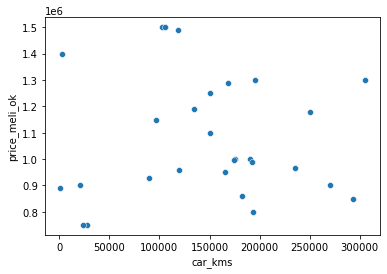

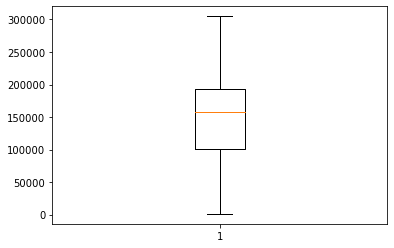

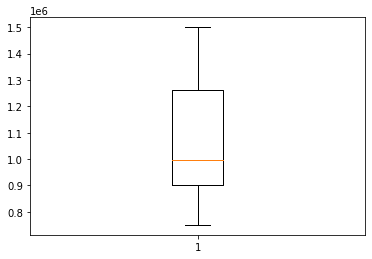

In [126]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

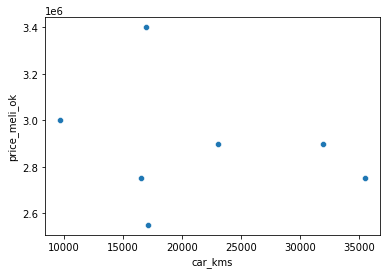

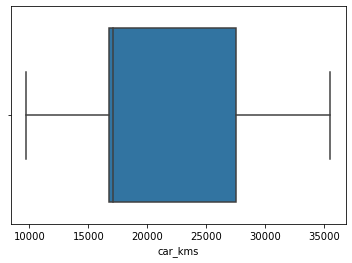

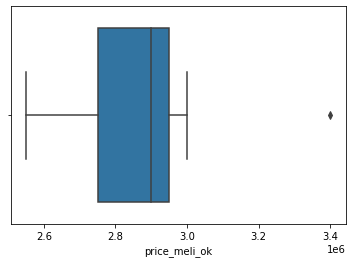

In [127]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

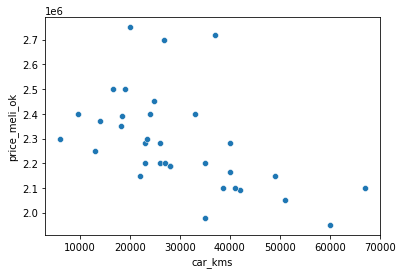

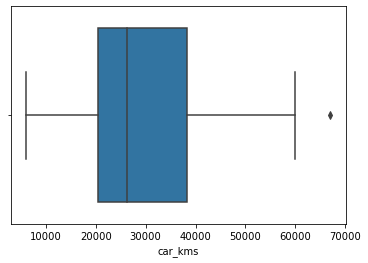

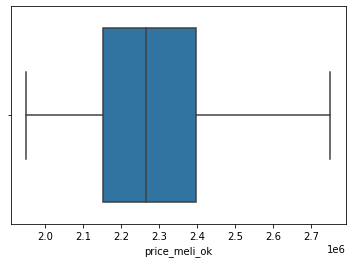

In [128]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

In [129]:
mask1 = df_train.match_modelo_a == 'Gol Trend'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

2763875.0
0


Si bien es cierto que siguen apareciendo outliers, esto es normal debido a que con el tratamiento que hicimos la distribucion cambia y es logico que ahora un valor que antes no se consideraba outliers si se considere. Lo bueno es que ahora estos outliers ya no son tan extremos e irriorios.

In [130]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1366000.0, 3662000.0),
 '2008_2017': (1650000.0, 3750000.0),
 '2008_2018': (1300000.0, 4625000.0),
 '2008_2019': (2623000.0, 4376500.0),
 '2008_2020': (975000.0, 6487500.0),
 '2008_2021': (2320000.0, 5260000.0),
 '206_2006': (330000.0, 1310000.0),
 '206_2007': (225000.0, 1380000.0),
 '206_2009': (465000.0, 1147500.0),
 '206_2010': (420000.0, 1260000.0),
 '206_2011': (567850.0, 1226200.0),
 '206_2012': (660000.0, 1430000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (1500000.0, 1500000.0),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007': (850000.0, 850000.0),
 '207_2009': (64500.0, 201

In [131]:
# Guardamos los diccionarios con la info de outiers thresholds en formato json
with open('{}kms_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(kms_thresh_outliers, outfile)

with open('{}price_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(price_thresh_outliers, outfile)

Notesé que en muchos casos nos quedan "nan", eso es porque aveces no tenemos ningun registro de un marca-modelo para un cierto año en particular (ej: talvez no se fabrico ese modelo durante ese año o cosas así). Por lo único que tendremos que tener cuidado es cuando apliquemos este cleaning sobre test, vamos a tener que poner un "if" que haga un "pass" en caso de que los thresh seas "nan"

In [132]:
df_train.to_csv('{}df_train_checkpoint_4.pkl'.format(path_save)) # este es el df_train final!
# el test sigue igual

# Applying data cleaning in the test set

In [7]:
df_train_ok = pd.read_csv('{}df_train_checkpoint_4.pkl'.format(path_save))

In [8]:
df_test = pd.read_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

In [9]:
print(df_train_ok.shape)
print(df_test.shape)

(24559, 10)
(6219, 10)


In [7]:
# Aplicamos el data cleaning aprendido en train sobre el set de test para usarlo en la evaluacion
df_test_ok = data_processing_1(df_test,path_save)

Hey! 206 were removed from df due to outliers under context


In [8]:
df_test_ok.shape

(6013, 10)

In [9]:
df_test_ok.to_csv('{}df_test_checkpoint_4.pkl'.format(path_save)) # este es el df_test final!

In [10]:
df_test_ok = pd.read_csv('{}df_test_checkpoint_4.pkl'.format(path_save))
df_test_ok.shape

(6013, 11)

# Modelling

In [11]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [12]:
# Volvemos a separar en X e y
X_train = df_train_ok[model_features]
y_train = df_train_ok.price_meli_ok

X_test = df_test_ok[model_features]
y_test = df_test_ok.price_meli_ok

## Modelo Baseline

In [13]:
X_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'Subseg_a', 'Seg_a'],
      dtype='object')

In [14]:
# Recordar agregar esto en la funcion de procesamiento para la simulacion

# Cuando hice el tratamiento de 1111 y 99999 había pasado la feature de kms a int. Volvemos a pasar a float por el catboost
X_train['car_kms'] = X_train['car_kms'].astype('float')
X_test['car_kms'] = X_test['car_kms'].astype('float')

# probamos tanto usando year como int y como float y la perfo del modelo dio apenas mejor con year en float
X_train['car_year'] = X_train['car_year'].astype('float')
X_test['car_year'] = X_test['car_year'].astype('float')

In [15]:
X_train.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_a         object
Subseg_a           object
Seg_a              object
dtype: object

In [16]:
np.where(X_train[model_features].dtypes != np.float)[0]

array([2, 3, 4, 5, 6])

In [17]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Train set evaluation:
_____________________________________
MAE: 193944.1978036388
MAPE: 8.806923336504656
MEDAPE: 6.636731720706433
MSE: 88637102132.99011
RMSE: 297719.83832621924
R2 Square 0.9672594919076991
__________________________________
Test set evaluation:
_____________________________________
MAE: 202193.31162599756
MAPE: 9.029845029298704
MEDAPE: 6.799181711079146
MSE: 102934926604.01501
RMSE: 320834.73409843736
R2 Square 0.9613631443917732
__________________________________


In [18]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,car_year,24.75
1,Subseg_a,24.55
2,match_marca_a,19.55
3,match_modelo_a,10.28
4,match_v1_a,8.13
5,car_kms,6.58
6,Seg_a,6.15


In [19]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v4.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

## Rangos para la prediccion

###  a) en base a castigar/premiar kms

In [21]:
# backup copies
X_test_v2 = X_test.copy()
y_test_v2 = y_test.copy()
# creamos un id
X_test_v2 = X_test_v2.reset_index().rename(columns={'index':'ID'})
y_test_v2 = y_test_v2.reset_index().rename(columns={'index':'ID'})

In [22]:
X_test_v2.head()

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
0,0,2014.00,150000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
1,1,2017.00,48059.00,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
2,2,2011.00,139000.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
3,3,2011.00,198000.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
4,4,2016.00,53000.00,BMW,X5,3.0 Executive,SUV Premium,SUV


In [24]:
# Prueba con un caso puntual -> OK
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)

mask = X_test_v2.ID == 3
castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
orig_ser = X_test_v2[mask]
castig_ser = orig_ser.copy()
castig_ser['car_kms'] = castig_val
prem_ser = orig_ser.copy()
prem_ser['car_kms'] = prem_val
X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])
X_test_v3

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
3,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
3,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos


In [25]:
# Creamos los registros con km castigado/premiado
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)
for idi in list(X_test_v2.ID):
    mask = X_test_v2.ID == idi
    castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
    prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
    orig_ser = X_test_v2[mask]
    castig_ser = orig_ser.copy()
    castig_ser['car_kms'] = castig_val
    prem_ser = orig_ser.copy()
    prem_ser['car_kms'] = prem_val
    X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])

In [26]:
X_test_v3.head(10)

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a
0,0,2014.00,120000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
0,0,2014.00,180000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes
1,1,2017.00,38447.20,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
1,1,2017.00,57670.80,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos
2,2,2011.00,111200.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
2,2,2011.00,166800.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV
3,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
3,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos
4,4,2016.00,42400.00,BMW,X5,3.0 Executive,SUV Premium,SUV
4,4,2016.00,63600.00,BMW,X5,3.0 Executive,SUV Premium,SUV


In [27]:
test_pred_ranges = model.predict(X_test_v3.drop('ID',1))
X_test_v3['pred'] = test_pred_ranges

In [28]:
# el rango que se genera es demasiado pequeño, no nos sirve para nuestros fines
# el impacto que tiene kms no hace tanto la diferencia.
X_test_v3.merge(y_test_v2, on = 'ID').head(10)

,ID,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,pred,price_meli_ok
0,0,2014.00,120000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes,2869448.64,2842800.00
1,0,2014.00,180000.00,VOLKSWAGEN,Passat,Variant 2.0 TSi Luxury DSG Techo (211cv) (L11),Gama Grandes Sedan,Gama Grandes,2700911.36,2842800.00
2,1,2017.00,38447.20,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos,4941679.39,6000000.00
3,1,2017.00,57670.80,CHEVROLET,S-10,2.8 TD DLX 4x4,Pickups Medianas-Grandes,Livianos,4844254.17,6000000.00
4,2,2011.00,111200.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV,4014354.42,4326000.00
5,2,2011.00,166800.00,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),SUV 4X4,SUV,3683293.25,4326000.00
6,3,2011.00,158400.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos,2316176.55,1153600.00
7,3,2011.00,237600.00,VOLKSWAGEN,Golf,1.6 Conceptline / Comfortline (100cv) (L07),Gama Medianos Hatchback,Gama Medianos,2102286.84,1153600.00
8,4,2016.00,42400.00,BMW,X5,3.0 Executive,SUV Premium,SUV,8762736.07,12772000.00
9,4,2016.00,63600.00,BMW,X5,3.0 Executive,SUV Premium,SUV,8129900.90,12772000.00


Vemos que el rango que se genera es demasiado acotado como para captar el target real. DESCARTAMOS ESTE APROACH

###  a) directamente sobre el output

In [25]:
# backup copies
X_test_v2 = X_test.copy()
y_test_v2 = y_test.copy()
# creamos un id
X_test_v2 = X_test_v2.reset_index().rename(columns={'index':'ID'})
y_test_v2 = y_test_v2.reset_index().rename(columns={'index':'ID'})

In [29]:
X_test_v2_subsamp = X_test_v2.iloc[0:5,:]
y_test_v2_subsam = y_test_v2.iloc[0:5,:]
test_pred = model.predict(X_test_v2_subsamp.drop('ID',1))

In [31]:
output = pd.DataFrame({'pred':test_pred, 'true': y_test_v2_subsam.price_meli_ok})
output

,pred,true
0,2773298.37,2842800.00
1,4947631.86,6000000.00
2,3863878.37,4326000.00
3,2216029.30,1153600.00
4,8504374.88,12772000.00


In [33]:
output['pred+10perc'] = output['pred']*1.1
output['pred-10perc'] = output['pred']*0.9
output = output[['pred','pred-10perc','pred+10perc','true']]
output

,pred,pred-10perc,pred+10perc,true
0,2773298.37,2495968.54,3050628.21,2842800.00
1,4947631.86,4452868.67,5442395.04,6000000.00
2,3863878.37,3477490.53,4250266.21,4326000.00
3,2216029.30,1994426.37,2437632.23,1153600.00
4,8504374.88,7653937.39,9354812.37,12772000.00


In [43]:
# ""Accuracy""
#and 
output['check'] = np.where((output['true'] >= output['pred-10perc']) & (output['true']<=output['pred+10perc']),1,0)
output

,pred,pred-10perc,pred+10perc,true,check
0,2773298.37,2495968.54,3050628.21,2842800.00,1
1,4947631.86,4452868.67,5442395.04,6000000.00,0
2,3863878.37,3477490.53,4250266.21,4326000.00,0
3,2216029.30,1994426.37,2437632.23,1153600.00,0
4,8504374.88,7653937.39,9354812.37,12772000.00,0


In [ ]:
col         = 'true'
conditions  = [(output[col] >= output['pred-10perc']) & (output[col]<=output['pred+10perc'])]
choices     = [ "high", 'medium', 'low' ]
    
df2["energy_class"] = np.select(conditions, choices, default=np.nan)

In [29]:
# seguir con el listado de abajo (prioridad: procesamiento para la simul y pasarle todo el pack denuevo a favio)

In [ ]:
# Prueba con un caso puntual -> OK
cols = X_test_v2.columns.tolist()
X_test_v3 = pd.DataFrame(columns=cols)

mask = X_test_v2.ID == 3
castig_val = (X_test_v2[mask]['car_kms'].item())*0.8
prem_val = (X_test_v2[mask]['car_kms'].item())*1.2
orig_ser = X_test_v2[mask]
castig_ser = orig_ser.copy()
castig_ser['car_kms'] = castig_val
prem_ser = orig_ser.copy()
prem_ser['car_kms'] = prem_val
X_test_v3 = pd.concat([X_test_v3, castig_ser, prem_ser])
X_test_v3

VOLVER A CORRER LA NB DE TRAIN CON DATA NUEVA POR DOS MOTIVOS:
    1) POR LE VIENE BIEN AL ALGORTIMO PARA LA PREDICCION
    2) PORQUE SE CORRIGIO LO DEL AÑO 2008 Y HAY QUE SUMAR A LOS JSON QUE CONTIENEN LA INFO DE OUTLIERS POR CONTEXTO, LA INFO DE LOS 2008. PARA SALIR DEL PASO LE HICE UN "PARCHE" A FUNC_COTIZADOR.PY

* Revision del sheets: OK
    - ver si los autos que predecimos mal son siempre los mismos o aveces los predecimos bien.
    - revisar si en la simulacion estan metiendosé casos de versiones que no se usaron para train --> esto era así debido a que lo de los grupos lo había hecho a nivel marca-modelo, ahora le agregue el nivel de version y esto se tendría que coregir... esperemos a ver los resultados de las simul
* Ajustar procesamiento. OK
    * Hacer la limpieza de categorias a nivel marca-modelo-version, para excluir tanto del entrenamiento como de las simulaciones las versiones con bajo vol. (esto podría generar que la variable version pase a tener mayor importance) --> dicho y hecho, así fue.<br>
de la mano con esto, calcular que % de versiones estan quedando afuera en cada marca-modelo (o a nivel general, validarlo con Pato)
* Si no funciona lo del rango en base a kms hacerlo sobre el output directamente (usaremos un 10% dado que el MAPE es 9%)
* Accucary en base al rango.
* Ajustar procesamiento en la simulacion
* Hacer la matriz de confu que hice para airtm


* Backlog:
    * Hacer procsamiento de la version usando lo de (L11) que sería 2011, en ese caso fijarnos que eso coincida con el con car_year, y sino coincide eliminar el registro (ver el chat con Emi) y luego re-entrenar.
    * Re-entrenar con un nuevo make_data más actualizado y actualizando el tipo de cambio
    * Optimizar hiperparametros a ver si logramos mejorar el mape (hacerlo desde la nube rappi) -- si con grid search no mejoramos, probar optuna

Cotizador

- cambios en el entrenamiento para el v4

	- score matcheo >= 80  (POST SPLIT)
	- limpieza de categorías a nivel marca-modelo-version (POST SPLIT)
	- solo incluimos grupos 1, 2 y 3 para el algoritmo (PRE SPLIT)
	- usamos 3 en lugar de 1.5 para el tratamiento de outliers por contexto (POST SPLIT)

- faltaría sumar estas modificaciones en el processing en la simulacion

## Optimización de Hiperparametros

In [157]:
# # A)
# parameters = {'depth'         : [6,8,10],
#               'learning_rate' : [0.01, 0.05, 0.1, 0.15],
#               'iterations'    : [100, 120, 150, 200, 250],
#               'l2_leaf_reg': [0.2, 0.5, 1, 3]
#              }


# #model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# # Results from Grid Search
# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    

# print("\n The best estimator across ALL searched params:\n",
#       grid.best_estimator_)

# print("\n The best score across ALL searched params:\n",
#       grid.best_score_)

# print("\n The best parameters across ALL searched params:\n",
#       grid.best_params_)

# print("\n ========================================================")

Mediante la optimizacion de hiperparametros con GridSearch no mejoramos la performance. Tener en cuenta que el baseline de Catboost se caracteriza por ser bastante optimo. De todas formas más adelante podríamos probar Optuna a modo de mejora.

Por lo tanto, nuestro mejor modelo lo obtenemos con el baseline de CatBoost.

## Evaluación

In [21]:
# los metodos que use en el desafio de airtm

In [159]:
# pending

## Validacion OOT

In [55]:
# pending

Mejoras:
* Sumar la feature de discontinuados (Favio)
* Features de InfoAutos (Cande se esta encargando de eso pero todavía no las tenemos)
* Mejor preprocesing a la feature version (ej: standarizar los valores para los casos de nula volatilidad en el precio)